In [1]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
img_folder = 'data/train_images/'
mask_folder = 'data/train_masks/'
fold_csv = 'data/masks.csv'


def prepare_test_transforms():
    transforms = [
        # A.Lambda(image=preprocess_input),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ChannelTranspose()
    ]
    return A.Compose(transforms)

def get_loaders():    
    datasets = OrderedDict()

    common = {
        'img_folder': img_folder,
        'mask_folder': mask_folder,
        'fold_csv': fold_csv,
        'num_classes': 4,
        'max_count': None
    }


    valid = ImageWithMaskDataset(
        **common,
        is_test=True,
        transforms=prepare_test_transforms()
    )

    datasets['valid'] = valid
    return datasets


In [4]:
def dice_channel_torch(probability, truth, threshold):
    batch_size = truth.shape[0]
    channel_num = truth.shape[1]
    mean_dice_channel = 0.
    with torch.no_grad():
        for i in range(batch_size):
            for j in range(channel_num):
                channel_dice = dice_single_channel(probability[i, j,:,:], truth[i, j, :, :], threshold)
                mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel


def dice_single_channel(probability, truth, threshold, eps = 1E-9):
    p = (probability.view(-1) > threshold).float()
    t = (truth.view(-1) > 0.5).float()
    dice = (2.0 * (p * t).sum() + eps)/ (p.sum() + t.sum() + eps)
    return dice

In [31]:

    
# from torch.jit import load
# model = load(f"{logdir}/checkpoints/best.pth").cuda()

# model = smp.FPN(encoder_name="timm-efficientnet-b3", classes=4)
# model.load(f"{logdir}/checkpoints/best.pth")
# import torch
# model.load_state_dict(torch.load(f"{logdir}/checkpoints/best.pth"))


In [5]:
from collections import OrderedDict
from catalyst.dl import SupervisedRunner
import segmentation_models_pytorch as smp
import ttach as tta
from mlcomp.contrib.dataset.segment import ImageWithMaskDataset
from catalyst.dl.callbacks import CheckpointCallback, InferCallback
import albumentations as A
from mlcomp.contrib.transform.albumentations import ChannelTranspose
from catalyst.dl import utils

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

loaders = get_loaders()
logdir = 'logs/fpn_timm-effb3'
runner = SupervisedRunner()

model = smp.FPN(encoder_name="timm-efficientnet-b3", classes=4)
checkpoint = utils.load_checkpoint(f"{logdir}/checkpoints/best.pth")
utils.unpack_checkpoint(checkpoint, model=model)

transforms = tta.Compose(
    [
        tta.Rotate90([0]), # NoOp
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
    ])

# transforms = tta.aliases.d4_transform()


# tta_model = model.cuda() 
tta_model = tta.SegmentationTTAWrapper(model.cuda(), transforms, merge_mode="mean")


runner = SupervisedRunner(model=tta_model, device=utils.get_device())

# runner = SupervisedRunner(device=utils.get_device(), input_key="image", input_target_key="mask")
# runner.infer(
#     model=tta_model,
#     loaders=loaders["valid"],
#     callbacks=OrderedDict([
#         ("infer", InferCallback())
#     ]),
# )



/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate b

  0%|          | 0/417 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for float

0.0021665699804910283


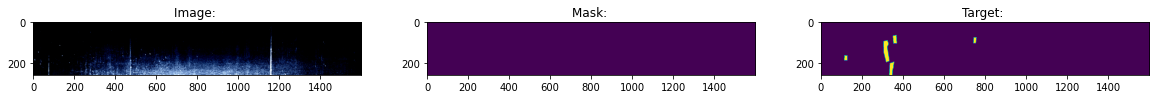

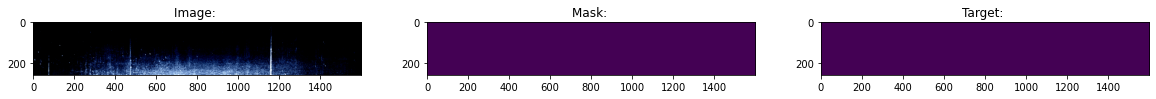

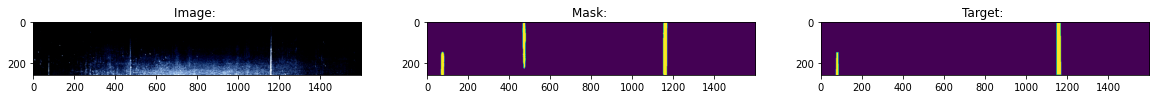

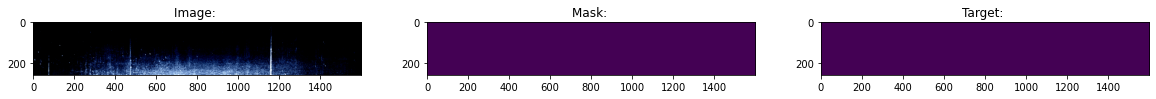

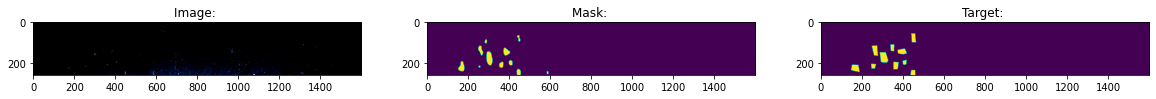

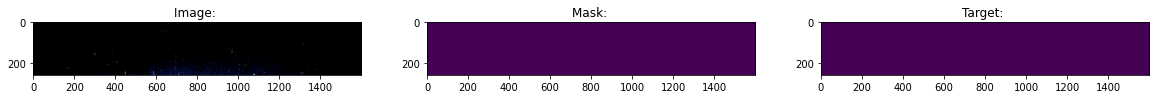

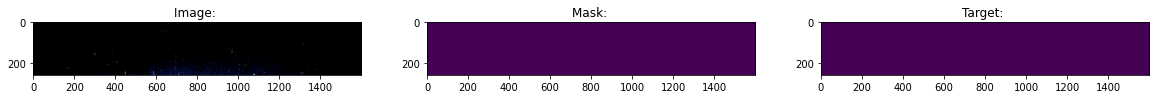

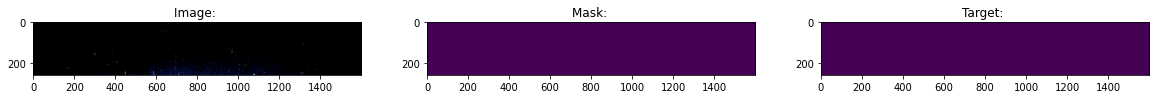

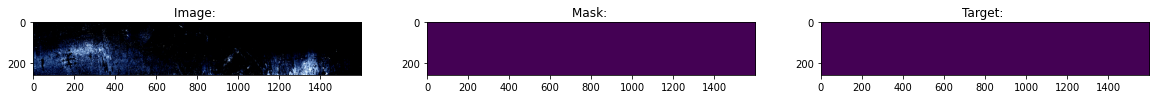

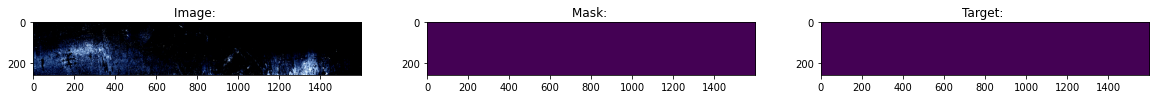

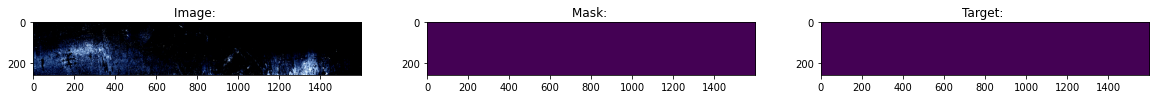

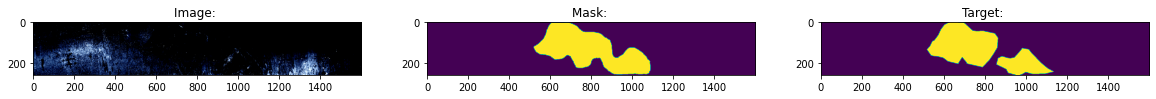

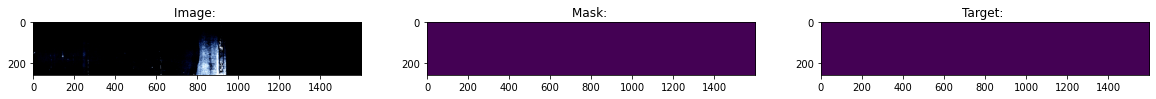

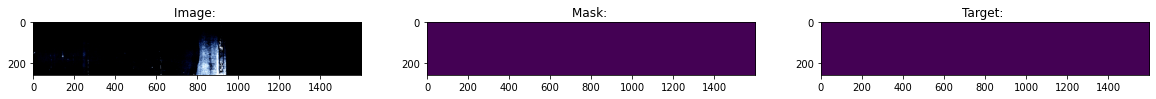

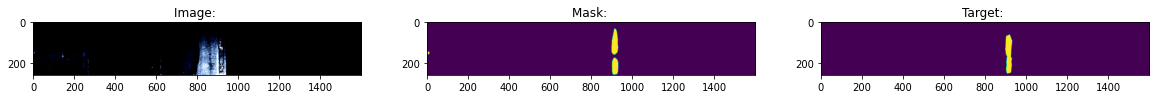

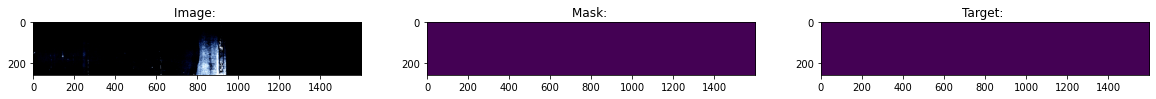

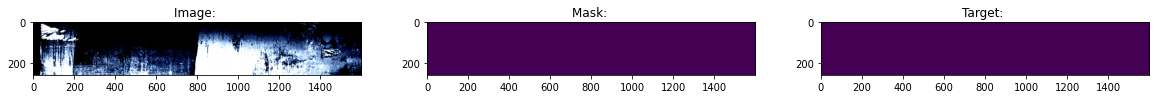

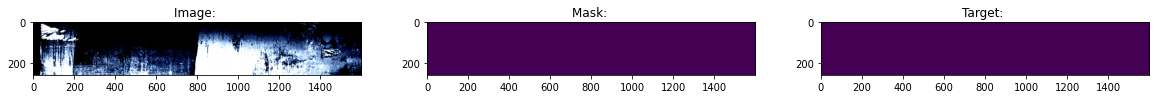

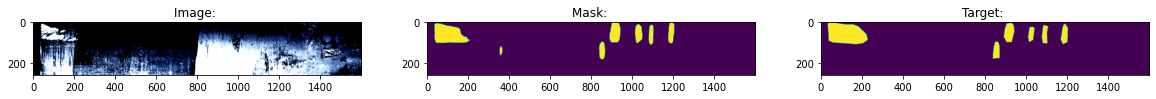

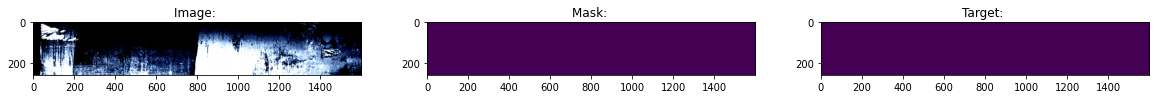

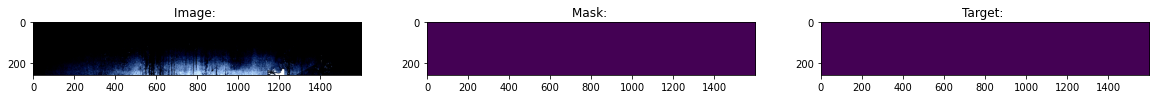

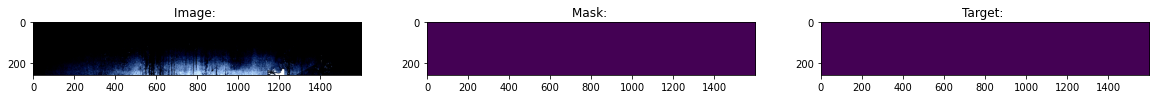

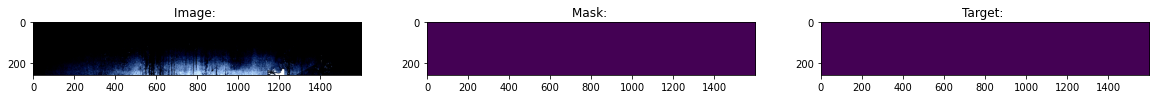

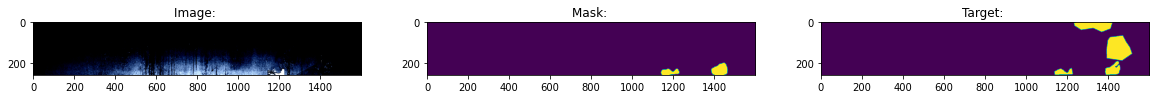

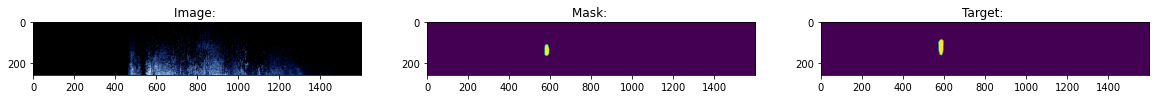

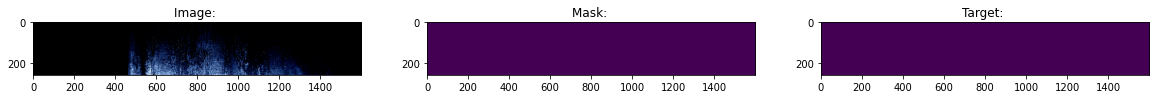

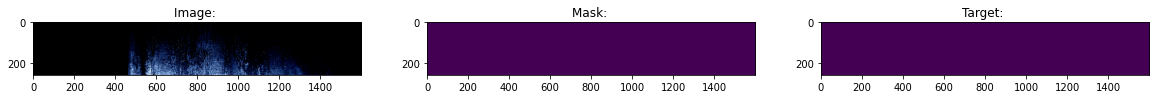

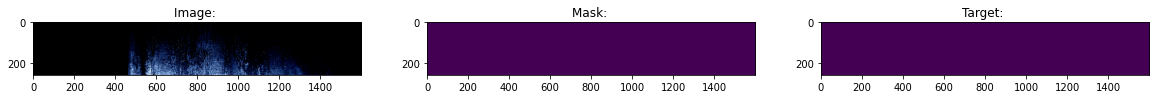

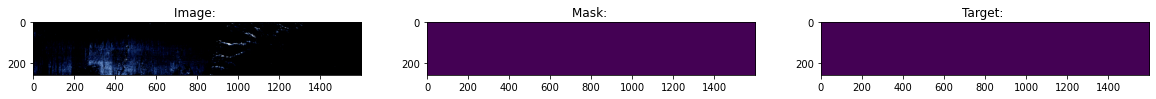

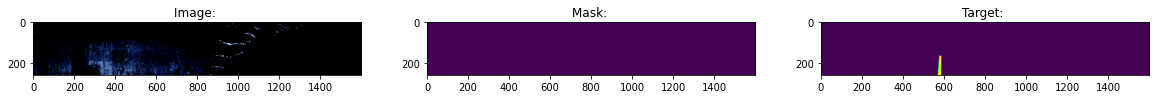

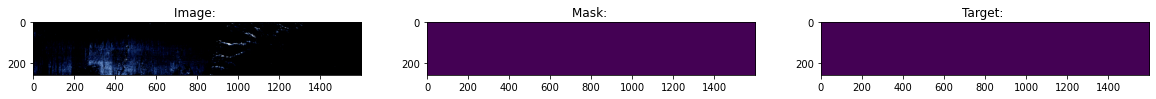

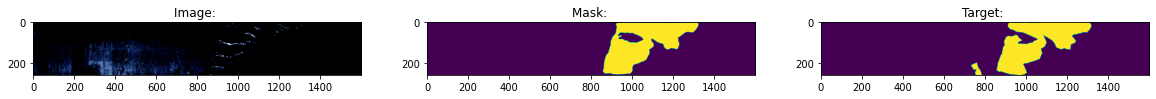

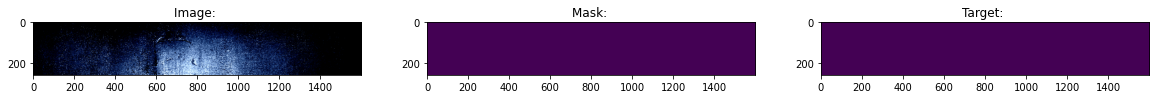

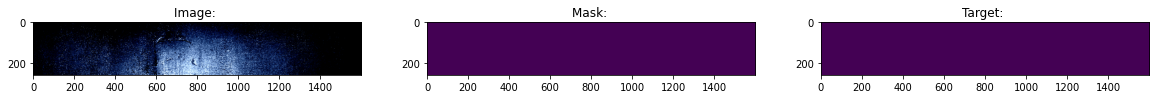

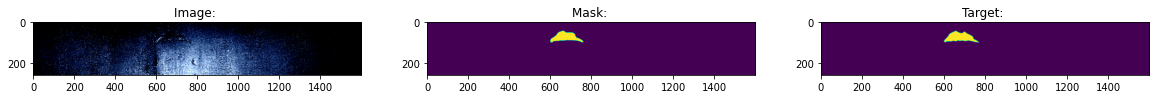

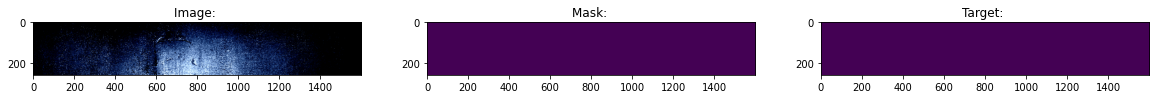

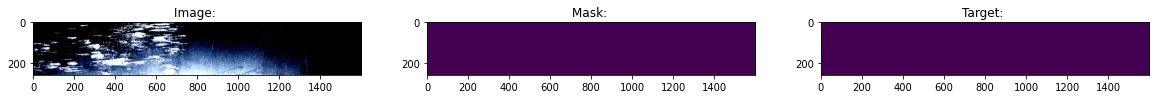

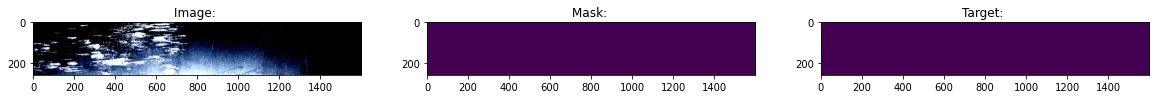

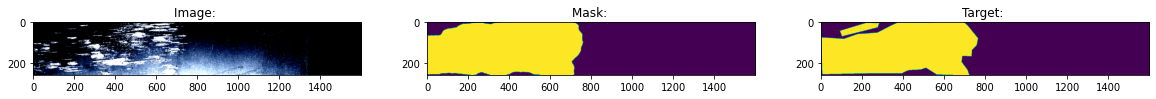

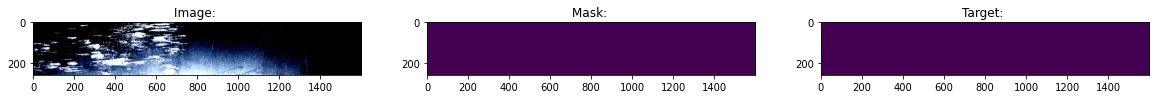

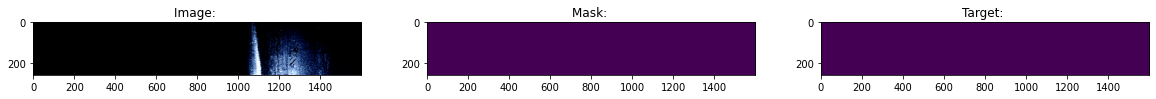

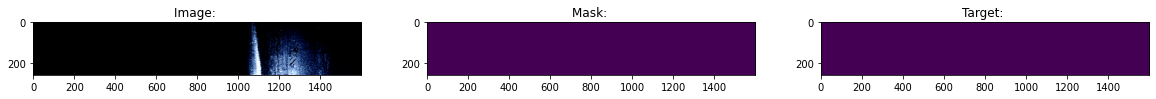

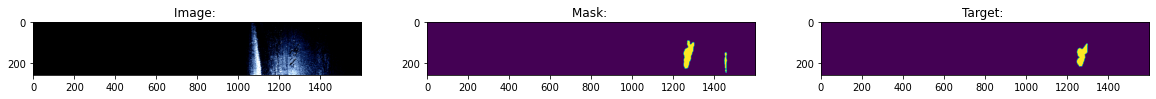

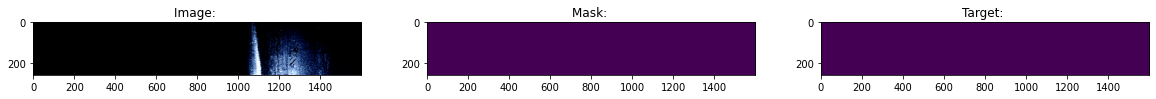

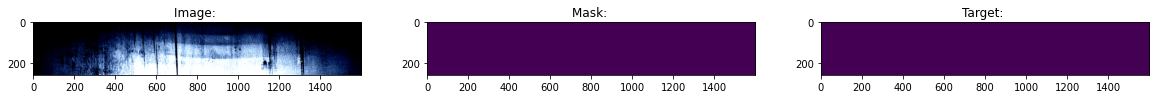

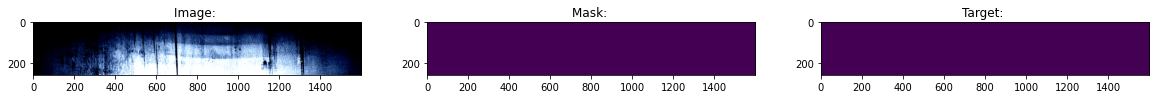

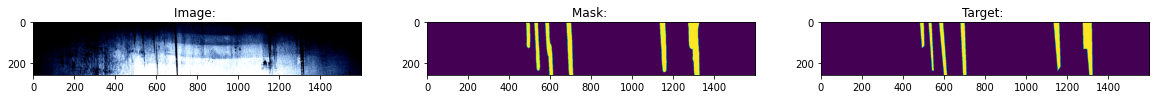

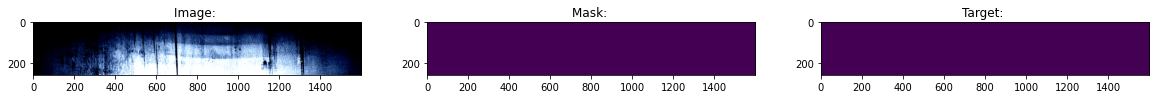

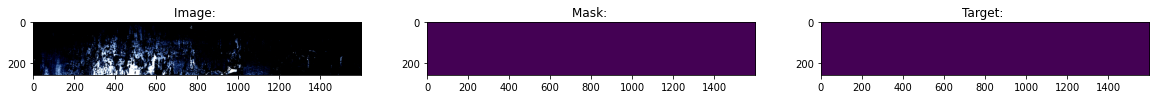

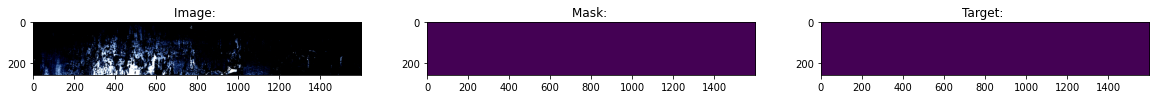

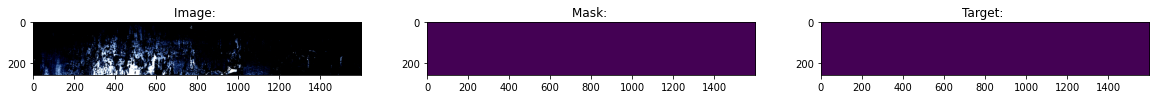

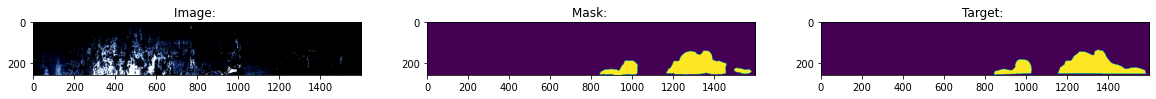

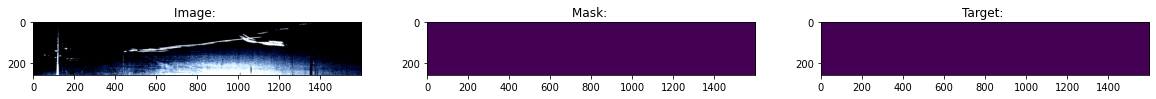

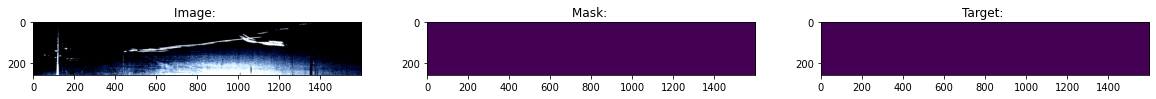

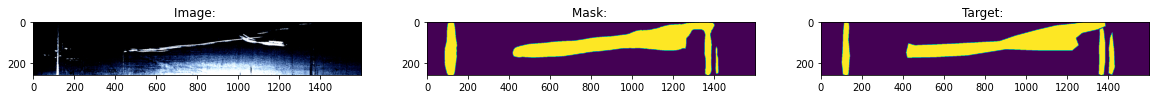

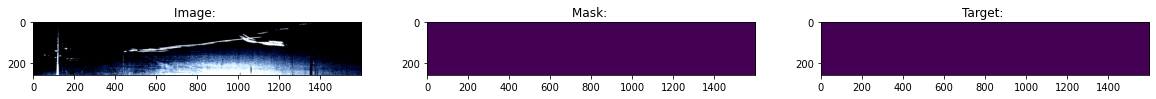

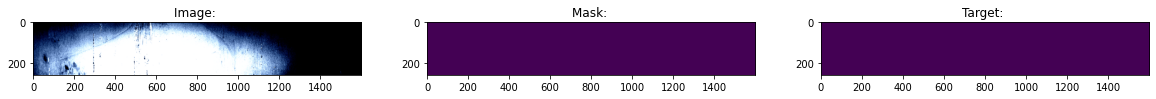

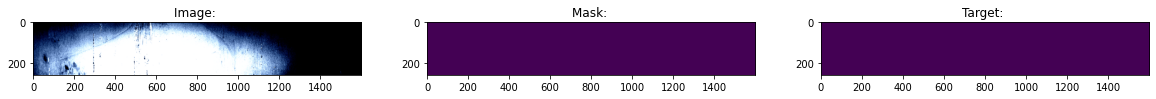

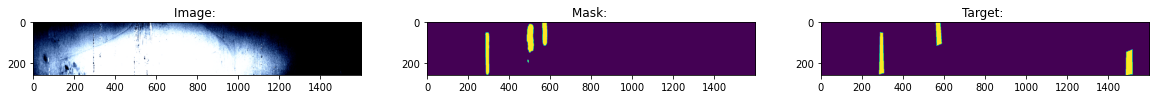

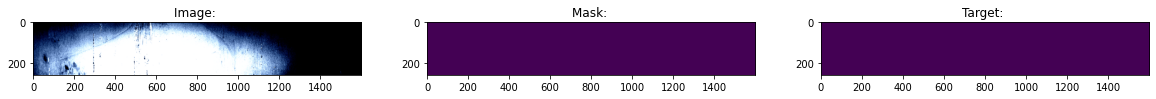

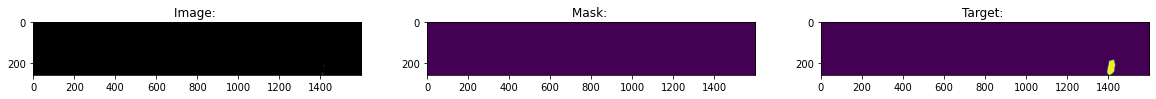

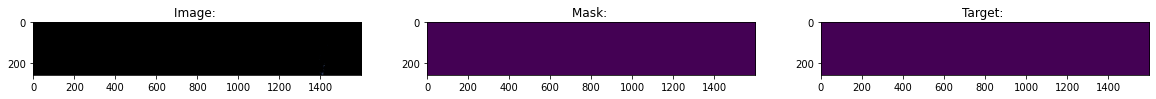

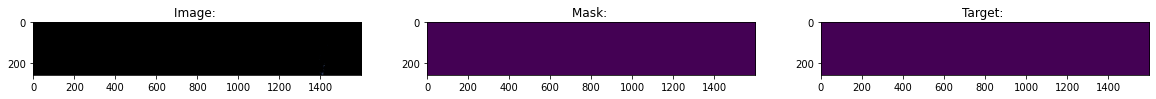

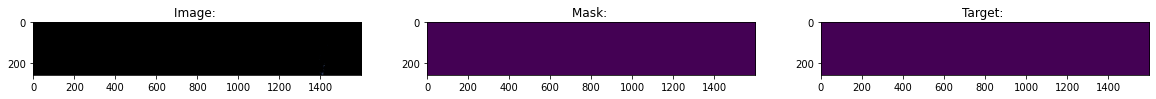

In [16]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)
import numpy as np
from skimage import morphology
thresholds = [.45, .45, .45, .45] #[0.7, 0.7, 0.6, 0.6]
min_area = [600, 600, 900, 2000]
regions_size = 512
batch_size = 16

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

def show_examples(name: str, image: np.ndarray, mask: np.ndarray, target: np.ndarray):
    plt.figure(figsize=(20, 28))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")

    plt.subplot(1, 3, 3)
    plt.imshow(target)
    plt.title(f"Target: {name}")
    
def dice_metric(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

    
import numpy as np
from torch.utils.data import DataLoader
infer_loader = DataLoader(
    loaders["valid"],
    batch_size=batch_size,
    pin_memory = True,
    shuffle=False,
#     num_workers=num_workers
)

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mlcomp.contrib.transform.albumentations import ChannelTranspose 

channelTranspose = ChannelTranspose(axes=(1, 2, 0))
dice = 0

for _, batch in enumerate(tqdm(infer_loader)):
#     logits = torch.sigmoid(runner.predict_batch({'features':batch['features'].cuda()})['logits'])    
    logits = torch.sigmoid(runner.predict_batch(batch)['logits'])    
    for image, targets, masks in zip(batch['features'], batch['targets'], logits):        
        masks = channelTranspose.apply(masks.cpu().numpy())
        image = channelTranspose.apply(image)
        targets = channelTranspose.apply(targets)
                
        # Image postprocessing
        for i in range(4):            
            mask = masks[...,i]    
            target = targets[...,i]    
            #порог предсказания вероятности
            mask = (mask>thresholds[i]).astype(np.uint8)
#             mask = (mask>.5).astype(np.uint8)
            #порог по минимальному региону
            mask = remove_small_regions(mask, regions_size)
            if mask.sum() < min_area[i]:
                mask = np.zeros(mask.shape, dtype=mask.dtype)
                
            dice += dice_metric(mask.flatten(), target.flatten())/4            

            show_examples(name="", image=image, mask=mask, target=target)
    
    break                
    
print(dice/(len(infer_loader.dataset)))


In [101]:
print(dice/(len(infer_loader.dataset)))

0.8045029423575992


In [ ]:
# model tracing
batch = next(iter(infer_loader))
# saves to `logdir` and returns a `ScriptModule` class
runner.trace(model=model, batch=batch, logdir=logdir)

!ls {logdir}/trace/

In [44]:
len(loaders['valid'].data)

6665

In [25]:
import numpy as np
import cv2
import torch.nn as nn
import torch 
import os
from catalyst.dl import utils
import albumentations as A
import ttach as tta
from albumentations.pytorch import ToTensorV2 as ToTensor
# from mlcomp.contrib.transform.albumentations import ChannelTranspose
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from skimage import morphology

thresholds = [.45, .45, .45, .45] #[0.7, 0.7, 0.6, 0.6]
min_area = [600, 600, 900, 2000]
regions_size = 512
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(20, 28))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")

# channelTranspose = ChannelTranspose(axes=(1, 2, 0))

class Predictor:
    def __init__(self, model_path):
        self.augmentation = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),ToTensor()])

        tta_transforms = tta.Compose(
            [
                tta.Rotate90([0]), # NoOp
                tta.HorizontalFlip(),
                tta.VerticalFlip(),
            ])        
        self.m = nn.Sigmoid()        
        self.model = self.load_model_traced(model_path)
        self.model = tta.SegmentationTTAWrapper(self.model, tta_transforms, merge_mode="mean")


        device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device_name)

    def load_model_traced(self, model_path):
        return utils.trace.load_traced_model(model_path).cuda()

    def load_model_checkpoint(self, model_path):    
        model = smp.FPN(encoder_name="timm-efficientnet-b3", classes=4)
        checkpoint = utils.load_checkpoint(model_path)
        utils.unpack_checkpoint(checkpoint, model=model)
        return model.cuda()

    def predict(self, image):
        augmented = self.augmentation(image=image)
        inputs = augmented['image']
        inputs = inputs.unsqueeze(0).to(self.device) 
        print(inputs.shape)
        logits = self.m(self.model(inputs)).cpu().numpy()[0]

        masks = logits.transpose(1,2,0)
                
        # Image postprocessing
        for i in range(4):            
            mask = masks[...,i]    
            #порог предсказания вероятности
            mask = (mask>thresholds[i]) 
            
            #порог по минимальному региону
            mask = remove_small_regions(mask, regions_size)
            if mask.sum() < min_area[i]:
                mask = np.zeros(mask.shape, dtype=mask.dtype)
            mask = mask.astype(np.uint8)
#             image[mask==1,0] = 255
            contours,_ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            for j in range(0, len(contours)):
                cv2.polylines(image, contours[j], True, palet[i], 2)                
                
#             show_examples(name="", image=image, mask=mask)
                
        return image
    
logdir = 'logs/fpn_timm-effb3'
model_path = f"{logdir}/trace/traced-best-forward.pth"

predictor = Predictor(model_path)

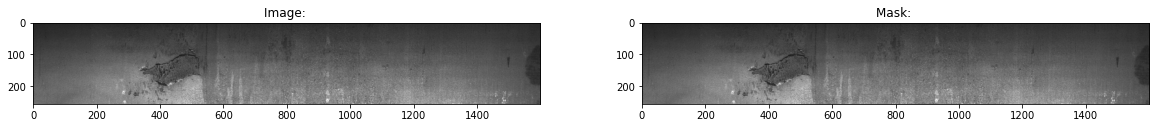

In [27]:
import cv2
image_file = 'data/test_images/0af0c1a38.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_examples(name="", image=image, mask=image)

torch.Size([1, 3, 256, 1600])


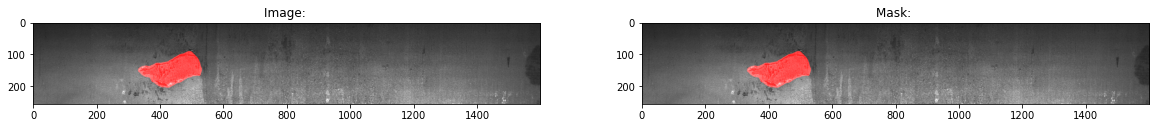

In [28]:
image = predictor.predict(image)
show_examples(name="", image=image, mask=image)